# Binary Classification with a Software Defects Dataset

__Aim__: predict defects in C programs given various various attributes about the code.

__Link to the competition__: [\<click!\>](https://www.kaggle.com/competitions/playground-series-s3e23)

__Score__: AUC = 0.793

___

### Approach
The approach of this work can be described as follows:
1. evaluate the basic models
2. create the ensembles of best-performing basic models (three models in one)
3. evaluate such ensembles and find out the one that performs best

___

### Modules import

In [35]:
# main modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

In [36]:
# modules used in data processing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import roc_auc_score

In [37]:
# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

___

### Functions

In [38]:
def all_combinations(params):
    """A func returns a list of all combinations of input parameters"""
    keys = list(params)
    combinations = []
    for values in itertools.product(*map(params.get, list(params))):
        combinations.append(dict(zip(keys, values)))
    return combinations

In [39]:
def cv(model):
    """A func cross-validates input model and returns an auc-score"""
    splitter = StratifiedKFold(n_splits=10, 
                               shuffle=True, 
                               random_state=1)
    auc_list = []
    for train_indexlist, validate_indexlist in splitter.split(X_train, y_train):
        X_t = train.iloc[train_indexlist]
        X_v = train.iloc[validate_indexlist]
        y_t = X_t.pop('defects')
        y_v = X_v.pop('defects')
        model.fit(X_t, y_t)
        try:
            y_pred = model.predict_proba(X_v)[:, 1]
        except AttributeError:
            y_pred = model.decision_function(X_v)
        auc_list.append(roc_auc_score(y_v, y_pred))
    auc = np.array(auc_list).mean()
    return auc

___

### EDA

In [40]:
# read the train set
train = pd.read_csv('train.csv', index_col='id').reset_index(drop=True)
train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [41]:
# DF size
train.shape

(101763, 22)

In [42]:
# check if there are some NaNs
train.isna().any().any()

False

In [43]:
# data types of features
train.dtypes

loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects                 bool
dtype: object

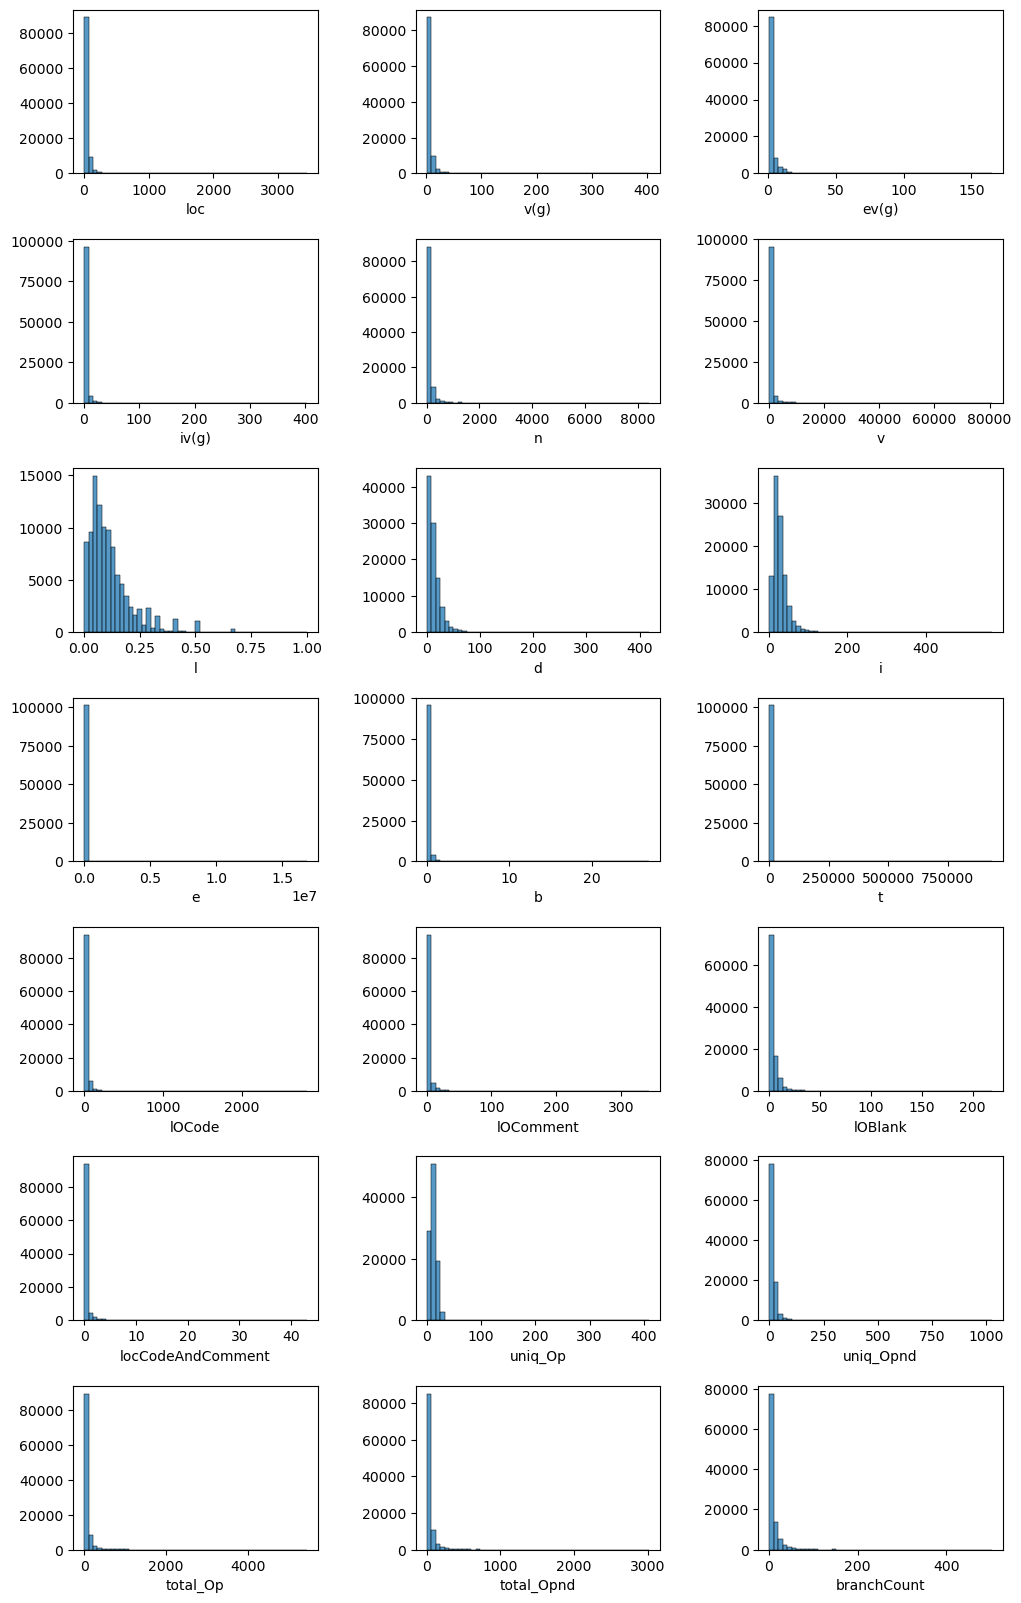

In [44]:
# plot distributions of each feature
fig, axs = plt.subplots(nrows=7, 
                        ncols=3, 
                        figsize=(12, 20))
for feature, ax in zip(train.drop('defects', axis=1).columns, axs.ravel()):
    sns.histplot(data=train, 
                 x=feature, 
                 ax=ax, 
                 bins=50)
    ax.set(ylabel='')
plt.subplots_adjust(wspace=.4, hspace=.4)

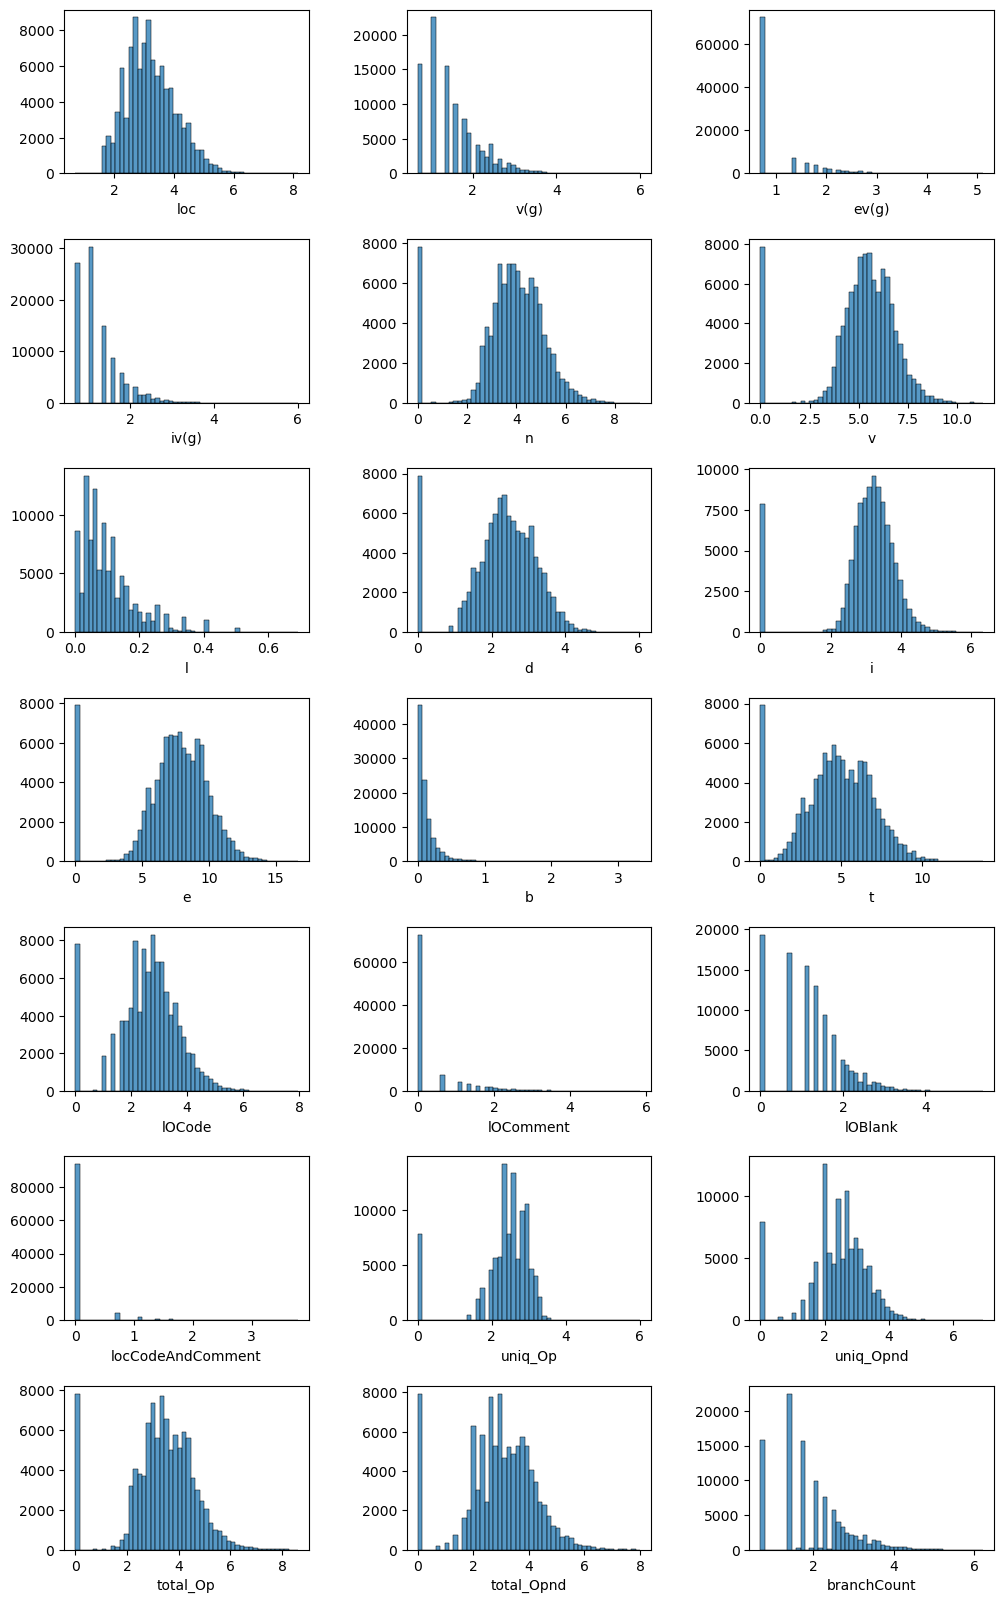

In [45]:
# it seems that it's better to apply a log transform to many features,
# for their distributions are left-skewed.
# so plot distributions of each fearute after x -> log(x + 1) transform
fig, axs = plt.subplots(nrows=7, 
                        ncols=3, 
                        figsize=(12, 20))
for feature, ax in zip(train.drop('defects', axis=1).columns, axs.ravel()):
    sns.histplot(data=np.log1p(train), 
                 x=feature, 
                 ax=ax, 
                 bins=50)
    ax.set(ylabel='')
plt.subplots_adjust(wspace=.4, hspace=.4)

In [46]:
# count a share of positive class; 
round(train.query('defects == True').shape[0] / train.shape[0], 2)

0.23

In [ ]:
# -> classes are imbalanced, so the implementation of stratified CV is needed

In [47]:
# initialize X_train, y_train
X_train = train.drop('defects', axis=1)
y_train = train.defects

___

### Basic models analysis
The basic models that are used in this work:
* Logistic Regression -- _labeled __logr___ -- with varying __C__
* Ridge Regression -- _labeled __ridge___ -- with varying __alpha__ and solving method (__solver__)
* Random Forest -- _labeled __rf___ -- with varying number of estimators (__n\_estimators__) and max depth of a tree (__max\_depth__)
* Extremely Randomized Trees (ExtraTrees) -- _labeled __et___ -- with varying max depth of a tree (__max\_depth__) and min number of samples in a leaf (__min\_samples\_leaf__)
* Histogram-based Gradient Boosting (HistGB) -- _labeled __hgb___ -- with varying min number of samples in a leaf (__min\_samples\_leaf__) and parameter of regularization (__l2\_regularization__)
* Extreme Gradient Boosting (XGBoost) -- _labeled __xgb___ -- with varying number of estimators (__n\_estimators__) and max depth of a tree (__max\_depth__)
* Adaptive Boosting (AdaBoost) -- _labeled __ada___ -- with varying base estimator (__estimator__)
* Light Gradient Boosting Machine (LightGBM) -- _labeled __lgb___ -- with varying  number of estimators (__n\_estimators__) and max depth of a tree (__max\_depth__)
* Categorical Boosting (CatBoost) -- _labeled __cat___ -- with varying max depth of a tree (__depth__)
* k-Nearest Neighbors (kNN) -- _labeled __knn___ -- with varying number of neighbors seen as nearest (__n\_neighbors__) and weights depending on a distance (__weights__)

Data for calculations is stored in a dictionary called __models__. This dictionary has such a structure:
* first level: { keys = _model's label_, values = _data for the model_ }
* second level: { keys = _hyperparameters of the model | pipeline template_, values = _corresponding values_ }

In [48]:
# set a dict of models to analyze
models = {
    # logistic regression
    'logr': {
        'params': {
            'C': np.logspace(-2, 1, 9),
            'class_weight': ['balanced'],
            'solver': ['newton-cholesky']
        },
        'template': lambda params: make_pipeline(FunctionTransformer(func=np.log1p),
                                                 PolynomialFeatures(degree=2, 
                                                                    include_bias=False),
                                                 StandardScaler(),
                                                 LogisticRegression(**params, 
                                                                    random_state=1, 
                                                                    max_iter=1500))
    },
    
    # logistic regression with kernel approximation
    'kernel_logr': {
        'params': {
            'C': np.logspace(-2, 1, 9),
            'class_weight': ['balanced'],
            'solver': ['newton-cholesky']
        },
        'template': lambda params: make_pipeline(FunctionTransformer(func=np.log1p),
                                                 Nystroem(n_components=400, 
                                                          random_state=1),
                                                 StandardScaler(),
                                                 LogisticRegression(**params, 
                                                                    random_state=1, 
                                                                    max_iter=1500))
    },
    
#     # ridge regression
#     'ridge': {
#         'params': {
#             'alpha': np.logspace(-2, 1, 9),
#             'class_weight': ['balanced'],
#             'solver': ['auto','cholesky']
#         },
#         'template': lambda params: make_pipeline(FunctionTransformer(func=np.log1p),
#                                                  PolynomialFeatures(degree=2, 
#                                                                     include_bias=False),
#                                                  StandardScaler(),
#                                                  RidgeClassifier(**params, 
#                                                                  random_state=1, 
#                                                                  max_iter=1500))
#     },
    
#     # random forest classifier
#     'rf': {
#         'params': {
#             'n_estimators': [100, 200],
#             'max_depth': [2, 3],
#             'min_samples_leaf': [50, 250]
#         },
#         'template': lambda params: RandomForestClassifier(**params, 
#                                                           random_state=1)
#     },
    
#     # extra trees classifier
#     'et': {
#         'params': {
#             'n_estimators': [100],
#             'max_depth': [2, 3],
#             'min_samples_leaf': range(50, 251, 50)
#         },
#         'template': lambda params: make_pipeline(FunctionTransformer(func=np.log1p),
#                                                  ExtraTreesClassifier(**params, 
#                                                                       random_state=1))
#     },
    
    # hist GB classifier
    'hgb': {
        'params': {
            'max_depth': [2],
            'min_samples_leaf': [25, 50, 250, 500],
            'l2_regularization': [0, 1, 10, 100]
        },
        'template': lambda params: HistGradientBoostingClassifier(**params, 
                                                                  random_state=1)
    },
    
    # XGBoost classifier
    'xgb': {
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [1, 2, 3, 4],
            'objective': ['reg:squarederror']
        },
        'template': lambda params: XGBClassifier(**params, 
                                                 random_state=1)
    },
    
    # AdaBoost classifier
    'ada': {
        'params': {
            'n_estimators': [50],
            'estimator': [DecisionTreeClassifier(max_depth=1), 
                          LogisticRegression(C=0.01, 
                                             class_weight='balanced', 
                                             solver='newton-cholesky', 
                                             max_iter=1500, 
                                             random_state=1),
                          LogisticRegression(C=0.1, 
                                             class_weight='balanced', 
                                             solver='newton-cholesky', 
                                             max_iter=1500, 
                                             random_state=1),
                         ]
        },
        'template': lambda params: make_pipeline(FunctionTransformer(func=np.log1p),
                                                 PolynomialFeatures(degree=2, 
                                                                    include_bias=False),
                                                 StandardScaler(),
                                                 AdaBoostClassifier(**params, 
                                                                    random_state=1))
    },
    
    # AdaBoost classifier with kernel approximation
    'kernel_ada': {
        'params': {
            'n_estimators': [50],
            'estimator': [DecisionTreeClassifier(max_depth=1), 
                          LogisticRegression(C=0.01, 
                                             class_weight='balanced', 
                                             solver='newton-cholesky', 
                                             max_iter=1500, 
                                             random_state=1),
                          LogisticRegression(C=0.1, 
                                             class_weight='balanced', 
                                             solver='newton-cholesky', 
                                             max_iter=1500, 
                                             random_state=1),
                         ]
        },
        'template': lambda params: make_pipeline(FunctionTransformer(func=np.log1p),
                                                 Nystroem(n_components=400, 
                                                          random_state=1),
                                                 StandardScaler(),
                                                 AdaBoostClassifier(**params, 
                                                                    random_state=1))
    },
    
    # light GB classifier
    'lgb': {
        'params': {
            'objective': ['binary'],
            'metric': ['auc'],
            'n_estimators': [25, 50, 150, 300],
            'max_depth': [1, 2, 3, 4]
        },
        'template': lambda params: LGBMClassifier(**params, 
                                                  verbose=-1, 
                                                  random_state=1)
        
    },
    
    # cat boost classifier
    'cat': {
        'params': {
            'depth': [1, 2, 3, 4, 5],
            'eval_metric': ['AUC'],
            
        },
        'template': lambda params: CatBoostClassifier(**params, 
                                                      silent=True, 
                                                      random_state=1)
    },
    
#     # kNN classifier
#     'knn': {
#         'params': {
#             'n_neighbors': range(100, 1001, 100),
#             'weights': ['uniform', 'distance']
#         },
#         'template': lambda params: make_pipeline(FunctionTransformer(func=np.log1p),
#                                                  StandardScaler(),
#                                                  KNeighborsClassifier(**params))
#     }
}

In [49]:
# create a dict to store the scores and parameters of the best models
best_models = {}
# for each model find the best score and parameters (e.g. fill best_models dict)
for modelname, data in models.items():
    best_score = 0
    best_params = {}
    for params in all_combinations(data['params']):
        model = data['template'](params)
        print('~ cross-validating {} model\n  with params {}\n\t...'.format(modelname, params))
        score = cv(model)
        print('\tdone! auc-score: {0:.4f}\n'.format(score))
        if score > best_score:
            best_score = score
            best_params = params
    best_models[modelname] = {
        'params': best_params,
        'score': best_score
    }

~ cross-validating logr model
  with params {'C': 0.01, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}
	...
	done! auc-score: 0.7893

~ cross-validating logr model
  with params {'C': 0.023713737056616554, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}
	...
	done! auc-score: 0.7896

~ cross-validating logr model
  with params {'C': 0.05623413251903491, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}
	...
	done! auc-score: 0.7898

~ cross-validating logr model
  with params {'C': 0.1333521432163324, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}
	...
	done! auc-score: 0.7899

~ cross-validating logr model
  with params {'C': 0.31622776601683794, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}
	...
	done! auc-score: 0.7899

~ cross-validating logr model
  with params {'C': 0.7498942093324559, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}
	...
	done! auc-score: 0.7897

~ cross-validating logr model
  with params {'C': 1.7782794100

	done! auc-score: 0.7806

~ cross-validating lgb model
  with params {'objective': 'binary', 'metric': 'auc', 'n_estimators': 25, 'max_depth': 2}
	...
	done! auc-score: 0.7879

~ cross-validating lgb model
  with params {'objective': 'binary', 'metric': 'auc', 'n_estimators': 25, 'max_depth': 3}
	...
	done! auc-score: 0.7897

~ cross-validating lgb model
  with params {'objective': 'binary', 'metric': 'auc', 'n_estimators': 25, 'max_depth': 4}
	...
	done! auc-score: 0.7907

~ cross-validating lgb model
  with params {'objective': 'binary', 'metric': 'auc', 'n_estimators': 50, 'max_depth': 1}
	...
	done! auc-score: 0.7854

~ cross-validating lgb model
  with params {'objective': 'binary', 'metric': 'auc', 'n_estimators': 50, 'max_depth': 2}
	...
	done! auc-score: 0.7896

~ cross-validating lgb model
  with params {'objective': 'binary', 'metric': 'auc', 'n_estimators': 50, 'max_depth': 3}
	...
	done! auc-score: 0.7911

~ cross-validating lgb model
  with params {'objective': 'binary', '

In [50]:
# print the content of best_models dict
for modelname in best_models:
    print('The best {} model:\n\tscore: {}\n\tparams: {}\n'.format(modelname, 
                                                                   best_models[modelname]['score'], 
                                                                   best_models[modelname]['params']))

The best logr model:
	score: 0.7898695099126962
	params: {'C': 0.1333521432163324, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}

The best kernel_logr model:
	score: 0.7913326770822939
	params: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}

The best hgb model:
	score: 0.7912221726117632
	params: {'max_depth': 2, 'min_samples_leaf': 250, 'l2_regularization': 10}

The best xgb model:
	score: 0.7919156541030976
	params: {'n_estimators': 200, 'max_depth': 2, 'objective': 'reg:squarederror'}

The best ada model:
	score: 0.7894741688024952
	params: {'n_estimators': 50, 'estimator': DecisionTreeClassifier(max_depth=1)}

The best kernel_ada model:
	score: 0.7895789054611914
	params: {'n_estimators': 50, 'estimator': LogisticRegression(C=0.1, class_weight='balanced', max_iter=1500,
                   random_state=1, solver='newton-cholesky')}

The best lgb model:
	score: 0.7921972103549404
	params: {'objective': 'binary', 'metric': 'auc', 'n_estimators': 300, '

In [51]:
# create a dataframe with best models' scores
best_models_df = pd.DataFrame()
for modelname, data in best_models.items():
    row = pd.DataFrame({'label': [modelname], 
                        'score': [data['score']]})
    best_models_df = pd.concat([best_models_df, row], 
                               ignore_index=True)
best_models_df = best_models_df.sort_values(by='score', ascending=False).reset_index(drop=True)
best_models_df

,label,score
0,cat,0.792703
1,lgb,0.792197
2,xgb,0.791916
3,kernel_logr,0.791333
4,hgb,0.791222
5,logr,0.789870
6,kernel_ada,0.789579
7,ada,0.789474


___

### Ensembles

In [52]:
# calculate a score threshold. let it be the mean value of best models' scores
score_threshold = best_models_df.score.mean()
score_threshold

0.7910366155905401

In [53]:
# find out which tree models to include in ensembles.
# their scores have to be better than previously calculated threshold
best_models_labels = list(best_models_df.query('score >= @score_threshold').label)
best_models_labels_dict = {
    'tree_models': [label for label in best_models_labels 
                    if label not in ['logr', 'kernel_logr', 'ada', 'kernel_ada']],
    'nontree_models': ['logr', 'kernel_logr', 'ada', 'kernel_ada']
}
best_models_labels_dict

{'tree_models': ['cat', 'lgb', 'xgb', 'hgb'],
 'nontree_models': ['logr', 'kernel_logr', 'ada', 'kernel_ada']}

In [54]:
# define all possible combinations of models for ensembles. 
# the main rule is that every ensemble has to include one non-tree model
ensemble_combinations = []
for item in itertools.combinations(best_models_labels_dict['tree_models'], 2):
    for nontree_item in best_models_labels_dict['nontree_models']:
        ensemble_combinations.append(list(itertools.chain(item)) + [nontree_item])
ensemble_combinations

[['cat', 'lgb', 'logr'],
 ['cat', 'lgb', 'kernel_logr'],
 ['cat', 'lgb', 'ada'],
 ['cat', 'lgb', 'kernel_ada'],
 ['cat', 'xgb', 'logr'],
 ['cat', 'xgb', 'kernel_logr'],
 ['cat', 'xgb', 'ada'],
 ['cat', 'xgb', 'kernel_ada'],
 ['cat', 'hgb', 'logr'],
 ['cat', 'hgb', 'kernel_logr'],
 ['cat', 'hgb', 'ada'],
 ['cat', 'hgb', 'kernel_ada'],
 ['lgb', 'xgb', 'logr'],
 ['lgb', 'xgb', 'kernel_logr'],
 ['lgb', 'xgb', 'ada'],
 ['lgb', 'xgb', 'kernel_ada'],
 ['lgb', 'hgb', 'logr'],
 ['lgb', 'hgb', 'kernel_logr'],
 ['lgb', 'hgb', 'ada'],
 ['lgb', 'hgb', 'kernel_ada'],
 ['xgb', 'hgb', 'logr'],
 ['xgb', 'hgb', 'kernel_logr'],
 ['xgb', 'hgb', 'ada'],
 ['xgb', 'hgb', 'kernel_ada']]

In [55]:
# create a dict to store the scores and models of the ensembles
ensembles = {}
# for each ensemble find the best score and structure (e.g. fill ensembles dict)
for combination in ensemble_combinations:
    ensemble = [(label, models[label]['template'](best_models[label]['params'])) for label in combination]
    modelname = 'ens({} + {} + {})'.format(*[label for label in combination])
    model = VotingClassifier(ensemble, voting='soft')
    print('~ cross-validating {} model\n\t...'.format(modelname))
    score = cv(model)
    print('\tdone! auc-score: {0:.4f}\n'.format(score))
    ensembles[modelname] = {
        'score': score,
        'model': model
    }

~ cross-validating ens(cat + lgb + logr) model
	...
	done! auc-score: 0.7923

~ cross-validating ens(cat + lgb + kernel_logr) model
	...
	done! auc-score: 0.7930

~ cross-validating ens(cat + lgb + ada) model
	...
	done! auc-score: 0.7928

~ cross-validating ens(cat + lgb + kernel_ada) model
	...
	done! auc-score: 0.7928

~ cross-validating ens(cat + xgb + logr) model
	...
	done! auc-score: 0.7923

~ cross-validating ens(cat + xgb + kernel_logr) model
	...
	done! auc-score: 0.7930

~ cross-validating ens(cat + xgb + ada) model
	...
	done! auc-score: 0.7927

~ cross-validating ens(cat + xgb + kernel_ada) model
	...
	done! auc-score: 0.7927

~ cross-validating ens(cat + hgb + logr) model
	...
	done! auc-score: 0.7921

~ cross-validating ens(cat + hgb + kernel_logr) model
	...
	done! auc-score: 0.7929

~ cross-validating ens(cat + hgb + ada) model
	...
	done! auc-score: 0.7927

~ cross-validating ens(cat + hgb + kernel_ada) model
	...
	done! auc-score: 0.7927

~ cross-validating ens(lgb +

In [56]:
# create a dataframe with scores of the ensembles
ensembles_df = pd.DataFrame()
for modelname, data in ensembles.items():
    row = pd.DataFrame({'label': [modelname], 
                        'score': [data['score']]})
    ensembles_df = pd.concat([ensembles_df, row], ignore_index=True)
ensembles_df = ensembles_df.sort_values(by='score', ascending=False).reset_index(drop=True)
ensembles_df

,label,score
0,ens(cat + xgb + kernel_logr),0.793024
1,ens(cat + lgb + kernel_logr),0.792986
2,ens(lgb + xgb + kernel_logr),0.792883
3,ens(cat + hgb + kernel_logr),0.792876
4,ens(cat + lgb + ada),0.792844
5,ens(cat + lgb + kernel_ada),0.792836
6,ens(xgb + hgb + kernel_logr),0.792766
7,ens(cat + xgb + ada),0.792738
8,ens(cat + xgb + kernel_ada),0.792729
9,ens(cat + hgb + ada),0.792680


___

### Results

In [57]:
# concat and sort two dataframes that include scores for the best models and ensembles
resulting_df = pd.concat([best_models_df, ensembles_df], ignore_index=True) \
    .sort_values(by='score', ascending=False) \
    .reset_index(drop=True)
resulting_df

,label,score
0,ens(cat + xgb + kernel_logr),0.793024
1,ens(cat + lgb + kernel_logr),0.792986
2,ens(lgb + xgb + kernel_logr),0.792883
3,ens(cat + hgb + kernel_logr),0.792876
4,ens(cat + lgb + ada),0.792844
5,ens(cat + lgb + kernel_ada),0.792836
6,ens(xgb + hgb + kernel_logr),0.792766
7,ens(cat + xgb + ada),0.792738
8,ens(cat + xgb + kernel_ada),0.792729
9,cat,0.792703


(0.7884741688024952, 0.7940238168126442)

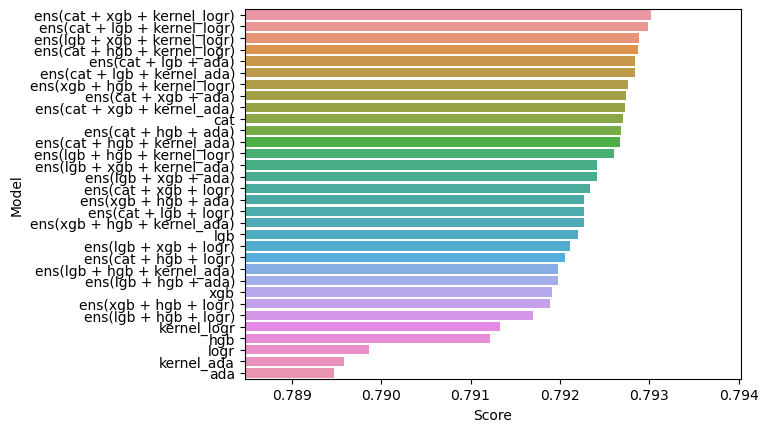

In [58]:
# make a barplot to illustrate the scores of models and ensembles
fig = sns.barplot(resulting_df, 
                  x='score', 
                  y='label')
fig.set(xlabel ='Score', ylabel = 'Model')
fig.set_xlim(resulting_df.score.min() - 0.001, 
             resulting_df.score.max() + 0.001) 

In [59]:
# get label of the best model
best_model_label = list(resulting_df.loc[resulting_df.score == resulting_df.score.max()].label)[0]
best_model_label

'ens(cat + xgb + kernel_logr)'

In [65]:
# initialize the best model as best_model and fit it on a train set
if best_model_label in list(best_models_df.label):
    best_model = models[best_model_label]['template'](best_models[best_model_label]['params'])
else:
    best_model = ensembles[best_model_label]['model']
best_model.fit(X_train, y_train)

VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x000002324F973E50>),
                             ('lgb',
                              LGBMClassifier(max_depth=2, metric='auc',
                                             n_estimators=300,
                                             objective='binary', random_state=1,
                                             verbose=-1)),
                             ('kernel_logr',
                              Pipeline(steps=[('functiontransformer',
                                               FunctionTransformer(func=<ufunc 'log1p'>)),
                                              ('nystroem',
                                               Nystroem(n_components=400,
                                                        random_state=1)),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=0.01,
                                                                  class_weight='balanced',
                                                                  max_iter=1500,
                                                                  random_state=1,
                                                                  solver='newton-cholesky'))]))],
                 voting='soft')

___

### Submission

In [66]:
# read the test set
test = pd.read_csv('test.csv', index_col='id')

In [67]:
# make predictions and store them in a proper format
predictions = best_model.predict_proba(test)[:, 1]
submission = pd.Series(predictions, 
                       index=test.index, 
                       name='defects')
submission.to_csv('submission_3.csv')

___